# Постановка задачи

С помощью **симплекс-метода** решить каноническую задачу линейного программирования:

$$J(u) = u_1 + u_2 - u_3 + u_5 \rightarrow \inf_{u \in U} $$

$$U = \{u = (u_1,u_2,u_3,u_4,u_5)^T \geq 0, u_1 + u_4 - u_5 = 1, u_1 + u_2 + 2u_4 = 3, u_3 + u_4 = 1\}$$

Перепишем задачу в следующем виде:

$$J(u) = \left<c,u\right> \rightarrow \inf_{u \in U} $$

$$U = \{u \in R^5 | u \geq 0, Au = b\}, $$

где 
$$A = \begin{bmatrix} 1 & 0 & 0 & 1 & -1 \\ 1 & 1 & 0 & 2 & 0 \\ 0 & 0 & 1 & 1 & 0 \end{bmatrix}, b = \begin{bmatrix} 1 \\ 3 \\ 1 \end{bmatrix}, c = \begin{bmatrix} 1 \\ 1 \\ -1 \\ 0\\ 1 \end{bmatrix}$$

Для начала нужно определиться с начальной **угловой точкой** $v_o \in U$. Найти её можно с помощью симплекс-метода, решив вспомогательную каноническую задачу ЛП. Для применения этого метода удобно считать, что выполняется условие $b > 0$ (если какая-то координата вектора $b$ отрицательна, умножаем на $(−1)$ соответствующее линейное уравнение в СЛАУ $Au = b$)

Предлагается рассмотреть следующую **вспомогательную каноническую задачу ЛП** в пространстве переменных $z = (x,u) \in R^{m+n}$, где $m$ - количество строк матрицы $A$, $n$ - размерность вектора $b$:

$$g(z) = x_1 + x_2 + ... + x_m \rightarrow min, z \in Z_0 = \{z \geq 0, x + Au = b\}$$

Точка $z_0 = (x=b,u=0)$ является угловой точкой канонического многогранника $Z_0$. Из этой точки можно запустить симплекс-метод, и он за конечное число шагов найдет решение $z_* = (x_*, v_*)$. Компонента $v_*$ будет угловой точкой многогранника U, из которой и будет запущен симплекс-метод для исходной задачи.

In [208]:
import numpy as np

In [281]:
A = np.array([[1, 0, 0, 1, -1], 
              [1, 1, 0, 2, 0], 
              [0, 0, 1, 1, 0]])
b = np.array([1, 3, 1]).reshape(-1, 1)
c = np.array([1, 1, -1, 0, 1]).reshape(-1, 1)

In [282]:
for i, elem in enumerate(b):
    if elem < 0:
        b[i] = elem*(-1)
        A[i] = A[i]*(-1)

In [283]:
def simplex_method(A, b, c, v, J_b):
    v_list = []
    while(True):
        J_f = np.array(list(set(np.arange(A.shape[1])).difference(set(J_b))))
        
        B_k = A[:, J_b]
        F_k = A[:, J_f]
        
        X = np.linalg.inv(B_k).dot(F_k) # (B^k)^{-1} * F^k
        delta_k = (X.T).dot(c[J_b]) - c[J_f]
        J_f_plus = J_f[np.where(delta_k > 0)[0]]
        
        if len(J_f_plus) == 0:
            break
        else:
            j_opt = min(J_f_plus)
            j_opt_add = min(np.where(delta_k > 0)[0])
            
            Y = np.linalg.inv(B_k).dot(A[:, j_opt]) # (B^k)^{-1} * A_{j_opt}
            
            if ((Y <= 0).sum() == Y.shape[0]):
                print('Решение не существует, J_* = -inf, U_* - пустое множество')
                return -1
            else:
                I_k = np.where(Y > 0)[0]
                I_k_plus = []
                
                u_opt = np.inf
                for i in I_k:
                    if (v[J_b[i]] / Y[i] == u_opt):
                        I_k_plus.append(J_b[i])
                    elif (v[J_b[i]] / Y[i] < u_opt):
                        u_opt = v[J_b[i]] / Y[i]
                        I_k_plus = [J_b[i]]
                
                u_f = np.zeros(A.shape[1] - A.shape[0])
                u_f[j_opt_add] = u_opt
                u_f = u_f.reshape(-1, 1)
                
                tmp = v[J_b] - (X @ u_f)
                v_next = np.zeros_like(v)
                v_next[J_b] = tmp
                v_next[J_f] = u_f
                v_list.append(v)
                v = v_next

                s_opt = min(I_k_plus)
                J_b = list(J_b)
                J_b.remove(s_opt)
                J_b.append(j_opt)
                J_b = np.array(sorted(J_b))
    v_list.append(v)
    return v, v_list

# Решение вспомогательной задачи

In [284]:
m = A.shape[0]
n = A.shape[1]

# матрица размера m*(m+n), у которой ранг равен m => её строки ЛНЗ
A_add = np.concatenate((np.eye(A.shape[0]), A), axis=1)

# вектор c = (1,...,1,0,...,0) из функционала g(z) = <c,z>
# количество единиц = m, количество нулей = n
c_add = np.concatenate((np.ones(m), np.zeros(n))).reshape(-1, 1)

# угловая точка z_0
z_0 = np.concatenate((b.reshape(-1, ), np.zeros(n))).reshape(-1, 1)

# номера базисных столбцов
J_b = np.arange(m)

In [285]:
# найдём начальную угловую точку для исходной задачи
v_0, v_list = simplex_method(A_add, b, c_add, z_0, J_b)
if type(v_0) != np.array:
    print('Начальная угловая точка v_0 = ', v_0.reshape(-1))

Начальная угловая точка v_0 =  [0. 0. 0. 1. 2. 1. 0. 0.]


# Решение основной задачи

In [292]:
# в данном случае ранг = 3 => можно взять первые три столбца
J_b = np.arange(m)

res, v_list = simplex_method(A, b, c, v_0[m:], J_b)
res = res.reshape(-1)

if type(res) != np.array:
    print('Решение найдено.\nu* = ', list(res))
    print('J* =', np.dot(res, c)[0])

Решение найдено.
u* =  [0.0, 1.0, 0.0, 1.0, 0.0]
J* = 1.0


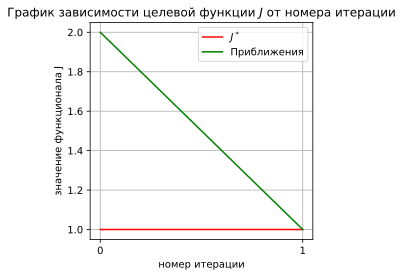

In [289]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
from scipy.optimize import linprog

x = np.arange(len(v_list))
y = [np.dot(u.reshape(-1),c)[0] for u in v_list]
opt = linprog(c, A_eq=A, b_eq=b).fun
plt.figure(figsize=(4,4))
plt.title(f'График зависимости целевой функции $J$ от номера итерации')
plt.plot(x, [opt for i in range(len(x))], color='r', label=f'$J^*$')
plt.plot(x, y, color='g', label='Приближения')
plt.xlabel('номер итерации')
plt.ylabel('значение функционала J')
plt.xticks(x)
plt.grid(True)
plt.legend()
plt.show()